In [ ]:

from numpy import asarray
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import glob
import os 
import random
import subprocess
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib.patches import Rectangle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
import os

# Base path to your local folder in Colab
base_path = "/content/rasitha"

# Subfolders representing different classes
categories = ["other_activities", "safe_driving", "talking_phone", "texting_phone", "turning"]

# Dictionary to store image paths
image_lists = {
    "other_activities": [],
    "safe_driving": [],
    "talking_phone": [],
    "texting_phone": [],
    "turning": []
}

# Loop through each category folder
for category in categories:
    folder_path = os.path.join(base_path, category)
    if os.path.exists(folder_path):
        for img_file in os.listdir(folder_path):
            if img_file.lower().endswith((".png", ".jpg", ".jpeg")):
                full_path = os.path.join(folder_path, img_file)
                image_lists[category].append(full_path)
                print(full_path)
    else:
        print(f"Folder not found: {folder_path}")

# Access images like
image_list_other = image_lists["other_activities"]
image_list_safe = image_lists["safe_driving"]
image_list_talking = image_lists["talking_phone"]
image_list_text = image_lists["texting_phone"]
image_list_turn = image_lists["turning"]


In [10]:
print("Number of samples in (Class = Other) = " ,len(image_list_other))
print("Number of samples in (Class = Safe Driving) = " ,len(image_list_safe))
print("Number of samples in (Class = Talking Phone) = " ,len(image_list_talking))
print("Number of samples in (Class = Texting Phone) = " ,len(image_list_text))
print("Number of samples in (Class = Turning) = " ,len(image_list_turn))

Number of samples in (Class = Other) =  2119
Number of samples in (Class = Safe Driving) =  2203
Number of samples in (Class = Talking Phone) =  2169
Number of samples in (Class = Texting Phone) =  2203
Number of samples in (Class = Turning) =  2057


In [13]:
train_other_df = pd.DataFrame({'image':train_other, 'label':'Other'})
train_safe_df = pd.DataFrame({'image':train_safe, 'label':'Safe'})
train_talking_df = pd.DataFrame({'image':train_talking, 'label':'Talk'})
train_text_df = pd.DataFrame({'image':train_text, 'label':'Text'})
train_turn_df = pd.DataFrame({'image':train_turn, 'label':'Turn'})

In [14]:
test_other_df = pd.DataFrame({'image':test_other, 'label':'Other'})
test_safe_df = pd.DataFrame({'image':test_safe, 'label':'Safe'})
test_talking_df = pd.DataFrame({'image':test_talking, 'label':'Talk'})
test_text_df = pd.DataFrame({'image':test_text, 'label':'Text'})
test_turn_df = pd.DataFrame({'image':test_turn, 'label':'Turn'})

In [15]:
valid_other_df = pd.DataFrame({'image':valid_other, 'label':'Other'})
valid_safe_df = pd.DataFrame({'image':valid_safe, 'label':'Safe'})
valid_talking_df = pd.DataFrame({'image':valid_talking, 'label':'Talk'})
valid_text_df = pd.DataFrame({'image':valid_text, 'label':'Text'})
valid_turn_df = pd.DataFrame({'image':valid_turn, 'label':'Turn'})

In [16]:
train_df = pd.concat([train_other_df, train_safe_df, train_talking_df, train_text_df, train_turn_df])
test_df = pd.concat([test_other_df, test_safe_df, test_talking_df, test_text_df, test_turn_df])
val_df = pd.concat([valid_other_df, valid_safe_df, valid_talking_df, valid_text_df, valid_turn_df])

In [17]:
train_df.head()

,image,label
0,/kaggle/input/revitsone-5class/Revitsone-5clas...,Other
1,/kaggle/input/revitsone-5class/Revitsone-5clas...,Other
2,/kaggle/input/revitsone-5class/Revitsone-5clas...,Other
3,/kaggle/input/revitsone-5class/Revitsone-5clas...,Other
4,/kaggle/input/revitsone-5class/Revitsone-5clas...,Other


In [18]:
print("Number of rows in train dataframe is: ", len(train_df))
print("Number of rows in test dataframe is: ", len(test_df))
print("Number of rows in val dataframe is: ", len(val_df))

Number of rows in train dataframe is:  8066
Number of rows in test dataframe is:  2148
Number of rows in val dataframe is:  537


In [21]:
Batch_size = 64
Img_height = 240
Img_width = 240

In [22]:
trainGenerator = ImageDataGenerator(rescale=1./255.)
valGenerator = ImageDataGenerator(rescale=1./255.)
testGenerator = ImageDataGenerator(rescale=1./255.)

In [23]:
trainDataset = trainGenerator.flow_from_dataframe(
  dataframe=train_df,
  class_mode="categorical",
  x_col="image",
  y_col="label",
  batch_size=Batch_size,
  seed=42,
  shuffle=True,
  target_size=(Img_height,Img_width) #set the height and width of the images
)

testDataset = testGenerator.flow_from_dataframe(
  dataframe=test_df,
  class_mode='categorical',
  x_col="image",
  y_col="label",
  batch_size=Batch_size,
  seed=42,
  shuffle=True,
  target_size=(Img_height,Img_width)
)

valDataset = valGenerator.flow_from_dataframe(
  dataframe=val_df,
  class_mode='categorical',
  x_col="image",
  y_col="label",
  batch_size=Batch_size,
  seed=42,
  shuffle=True,
  target_size=(Img_height,Img_width)
)

Found 8066 validated image filenames belonging to 5 classes.
Found 2148 validated image filenames belonging to 5 classes.
Found 537 validated image filenames belonging to 5 classes.


In [31]:
def VGGNet():
    inp = layers.Input((240, 240, 3))
    x = layers.Conv2D(64, 3, 1, activation='relu')(inp)
    x = layers.Conv2D(64, 3, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Conv2D(128, 3, 1, activation='relu')(x)
    x = layers.Conv2D(128, 3, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Conv2D(256, 3, 1, activation='relu')(x)
    x = layers.Conv2D(256, 3, 1, activation='relu')(x)
    x = layers.Conv2D(256, 3, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Conv2D(512, 3, 1, activation='relu')(x)
    x = layers.Conv2D(512, 3, 1, activation='relu')(x)
    x = layers.Conv2D(512, 3, 1, activation='relu')(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(5, activation='softmax')(x)

    model_VGG = models.Model(inputs=inp, outputs=x)

    return model_VGG

model_VGG = VGGNet()
model_VGG.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 238, 238, 64)      1792      
                                                                 
 conv2d_6 (Conv2D)           (None, 236, 236, 64)      36928     
                                                                 
 batch_normalization_2 (Batc  (None, 236, 236, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 118, 118, 64)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 116, 116, 128)     7385

In [33]:
model_VGG.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [34]:
VGG_model = model_VGG.fit(trainDataset, epochs=20, validation_data=valDataset)

Epoch 1/20
127/127 [==============================] - 149s 924ms/step - loss: 1.4044 - accuracy: 0.5568 - val_loss: 0.5468 - val_accuracy: 0.3240
Epoch 2/20
127/127 [==============================] - 111s 870ms/step - loss: 0.1390 - accuracy: 0.8760 - val_loss: 0.5148 - val_accuracy: 0.3650
Epoch 3/20
127/127 [==============================] - 111s 871ms/step - loss: 0.0815 - accuracy: 0.9312 - val_loss: 0.3111 - val_accuracy: 0.6313
Epoch 4/20
127/127 [==============================] - 111s 873ms/step - loss: 0.0562 - accuracy: 0.9535 - val_loss: 0.1301 - val_accuracy: 0.8771
Epoch 5/20
127/127 [==============================] - 111s 871ms/step - loss: 0.0487 - accuracy: 0.9603 - val_loss: 0.0765 - val_accuracy: 0.9292
Epoch 6/20
127/127 [==============================] - 111s 872ms/step - loss: 0.0433 - accuracy: 0.9669 - val_loss: 0.2301 - val_accuracy: 0.8156
Epoch 7/20
127/127 [==============================] - 111s 870ms/step - loss: 0.0361 - accuracy: 0.9699 - val_loss: 0.0717 -

In [35]:
training_loss_vgg = VGG_model.history['loss']
val_loss_vgg = VGG_model.history['val_loss']
training_acc_vgg = VGG_model.history['accuracy']
val_acc_vgg = VGG_model.history['val_accuracy']

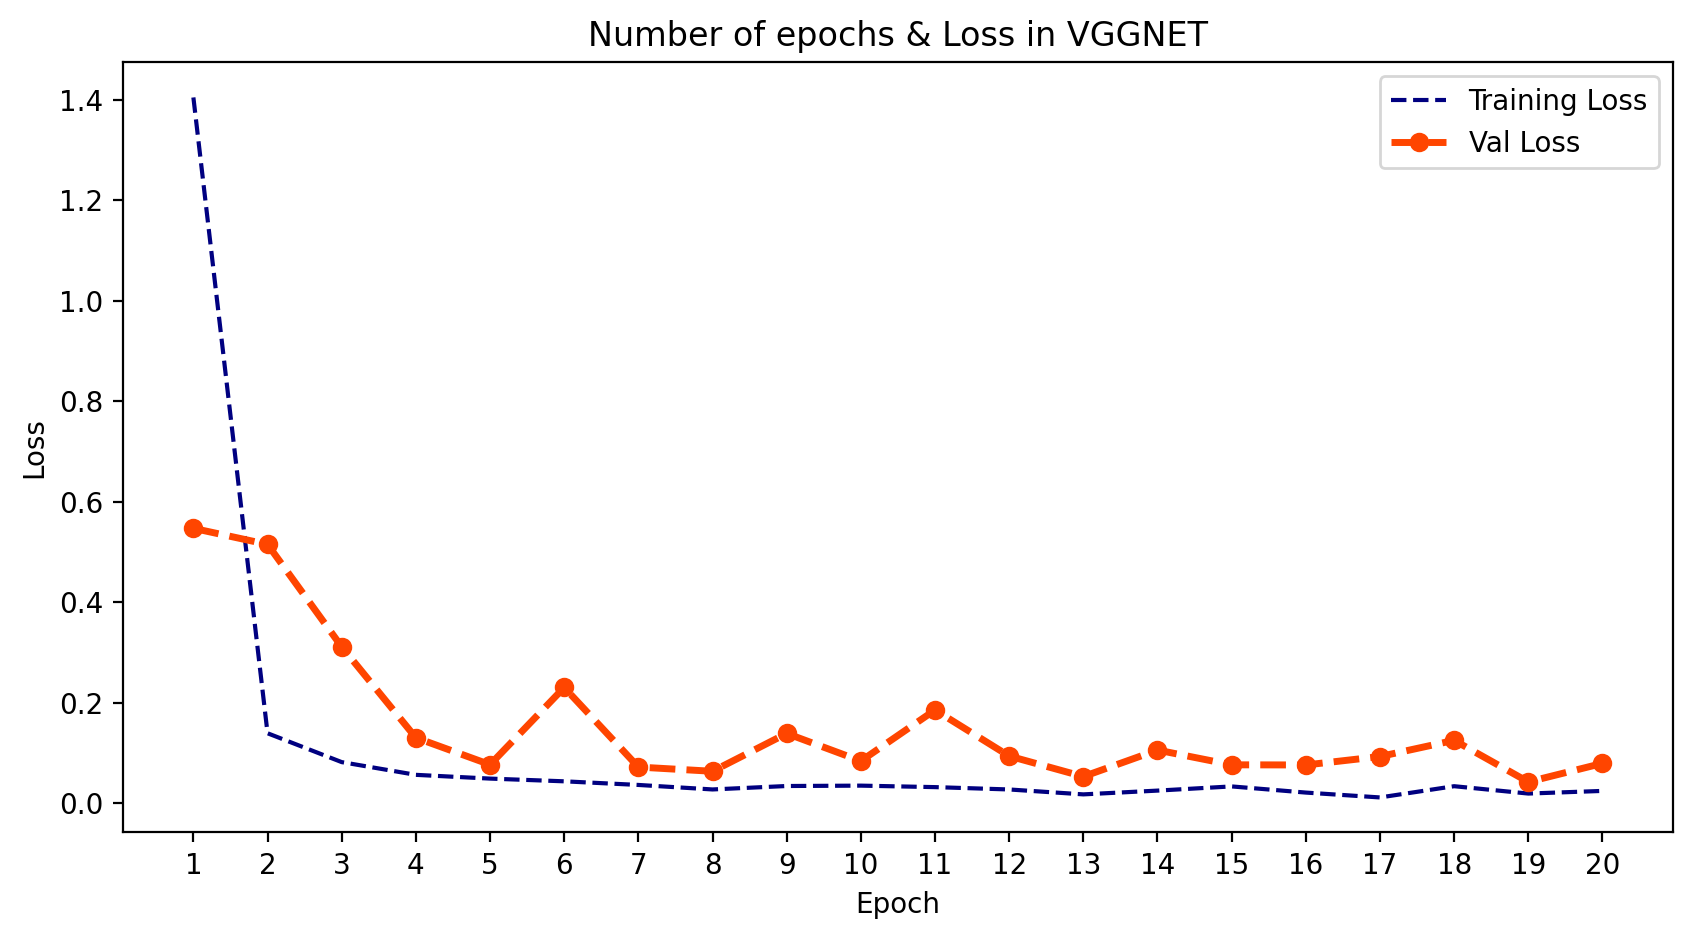

In [36]:
plt.figure(figsize=(10,5), dpi=200)
plt.plot(epoch_count, training_loss_vgg, 'r--', color= 'navy')
plt.plot(epoch_count, val_loss_vgg, '--bo',color= 'orangered', linewidth = '2.5', label='line with marker')
plt.legend(['Training Loss', 'Val Loss'])
plt.title('Number of epochs & Loss in VGGNET')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,21,1))
plt.show();

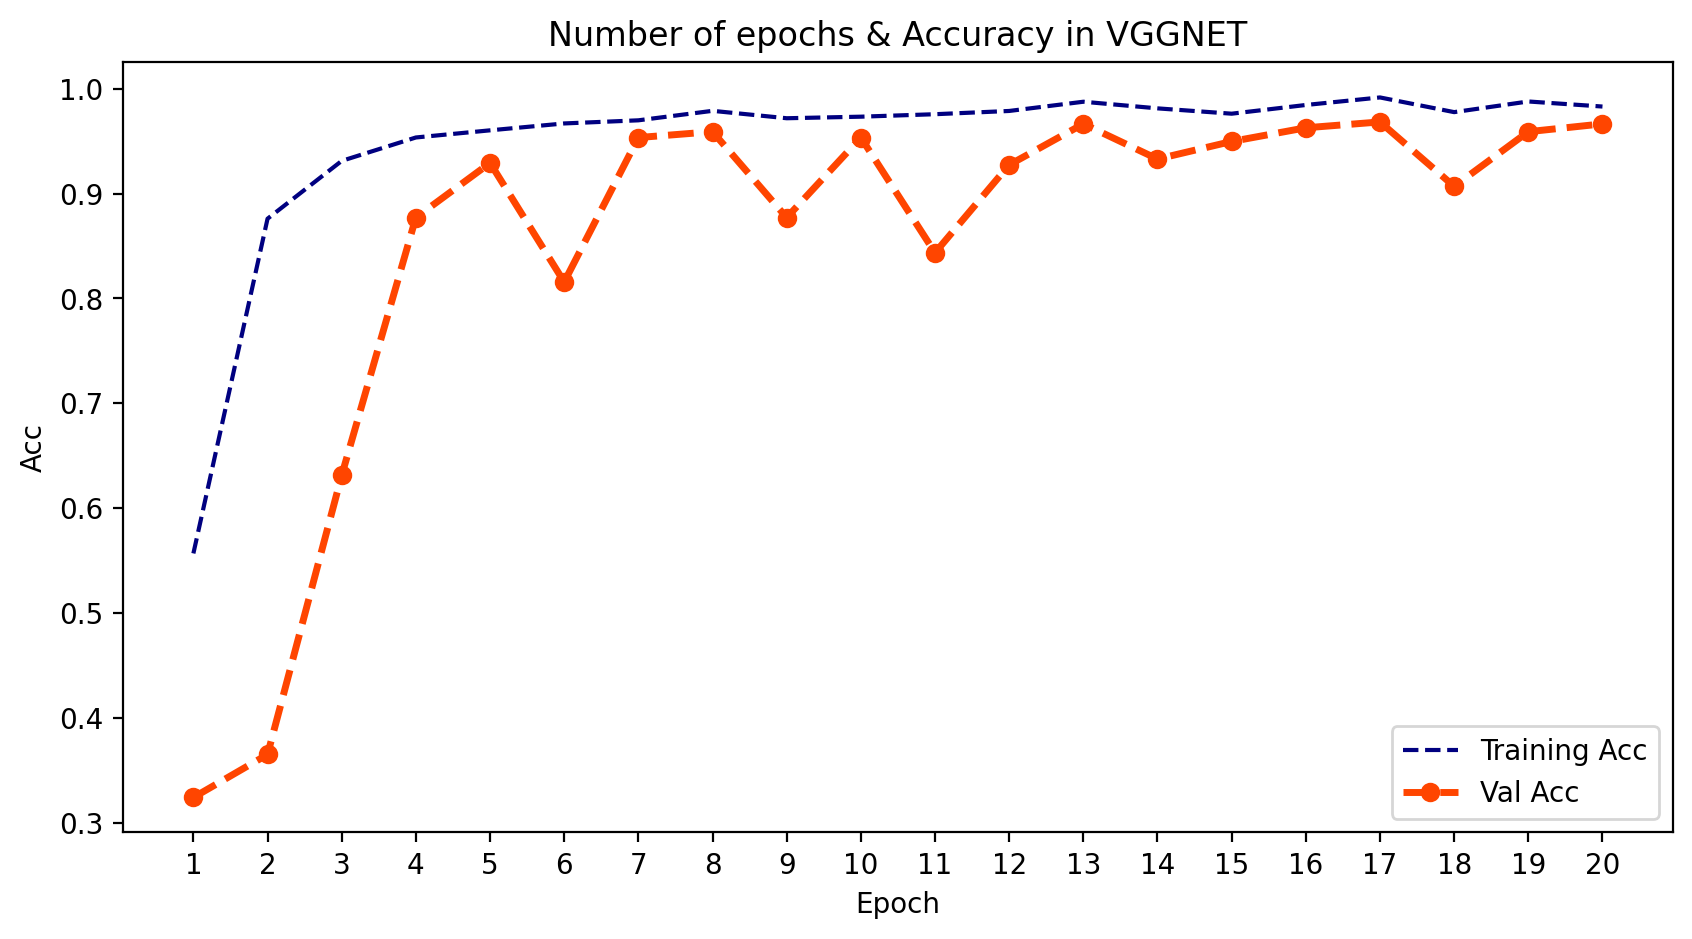

In [37]:
plt.figure(figsize=(10,5), dpi=200)
plt.plot(epoch_count, training_acc_vgg, 'r--', color= 'navy')
plt.plot(epoch_count, val_acc_vgg, '--bo',color= 'orangered', linewidth = '2.5', label='line with marker')
plt.legend(['Training Acc', 'Val Acc'])
plt.title('Number of epochs & Accuracy in VGGNET')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.xticks(np.arange(1,21,1))
plt.plot();
plt.show();